In [1]:
#Make directory name kaggle
! mkdir ~/.kaggle

In [2]:
#Copy the json kaggle to this directory
! cp kaggle.json ~/.kaggle/

In [3]:
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json


In [4]:
! kaggle datasets download -d awsaf49/artifact-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/artifact-dataset
License(s): other
100% 29.4G/29.4G [05:23<00:00, 148MB/s]
100% 29.4G/29.4G [05:23<00:00, 97.6MB/s]


# **Extract Data**

In [5]:
import zipfile

# Path to the dataset zip file
dataset_path = "/content/artifact-dataset.zip"
# Directory to extract the dataset
extracted_path = "/content/ArtiFact"

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Update the dataset path to the extracted directory
dataset_path = extracted_path


In [6]:
import os
import sys
import random
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# List to store sampled image paths and their corresponding targets
sampled_image_paths = []
sampled_targets = []

# Define the folder and number of images for 'styleGan2'
stylegan2_images_to_sample = 440000

# Iterate through each folder in the dataset
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        metadata_file_path = os.path.join(folder_path, 'metadata.csv')
        if os.path.exists(metadata_file_path):
            metadata_d = pd.read_csv(metadata_file_path)

            if folder_path == '/content/ArtiFact/stylegan2':
                # Sample 450000 images from 'styleGan2' folder
                sampled_metadata = metadata_d.sample(min(stylegan2_images_to_sample, len(metadata_d)), random_state=42)
            else:
                # Sample up to num_images_per_folder images from other folders
                sampled_metadata = metadata_d

            # Get sampled image paths and their corresponding targets
            sampled_image_paths.extend([os.path.join(folder_path, img_path) for img_path in sampled_metadata['image_path']])
            sampled_targets.extend(sampled_metadata['target'].tolist())

# Create a DataFrame with the sampled data
sampled_data_df = pd.DataFrame({'image_path': sampled_image_paths, 'target': sampled_targets})

# Modify targets: keep 0 as is, change anything else to 1
sampled_data_df['target'] = sampled_data_df['target'].apply(lambda x: 0 if x == 0 else 1)

# Shuffle the DataFrame
sampled_data_df = shuffle(sampled_data_df, random_state=42).reset_index(drop=True)

print("Total sampled images:", len(sampled_data_df))
print(sampled_data_df.head())


Total sampled images: 1936738
                                          image_path  target
0   /content/ArtiFact/lsun/horse/horse/img122358.jpg       0
1   /content/ArtiFact/lsun/horse/horse/img096456.jpg       0
2  /content/ArtiFact/taming_transformer/tt-ffhq/f...       1
3  /content/ArtiFact/face_synthetics/facesyn/imag...       1
4  /content/ArtiFact/lsun/church/church/train/img...       0


In [8]:
np.unique(sampled_data_df['target'],return_counts=True) #0 ---> Real

(array([0, 1]), array([964989, 971749]))

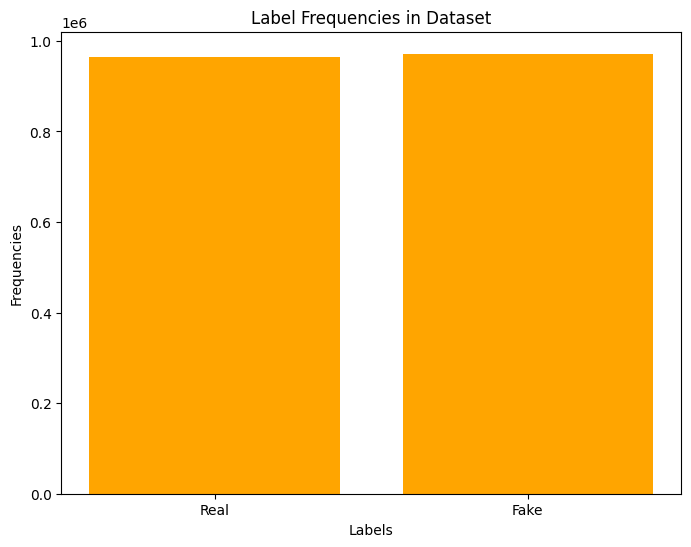

In [9]:
# Assuming sampled_data_df has been created as per the previous code
counter = Counter(sampled_data_df['target'])
freqs = list(counter.values())
labels = list(counter.keys())

# Map numerical labels to text labels
label_mapping = {0: 'Real', 1: 'Fake'}
text_labels = [label_mapping[label] for label in labels]

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(text_labels, freqs, color='orange')
plt.xticks(text_labels)  # Set x-ticks to be the text labels
plt.xlabel('Labels')
plt.ylabel('Frequencies')
plt.title('Label Frequencies in Dataset')
plt.show()


# **Split the Data and to get train_generator and test_generator**

In [22]:
sampled_data_df['target'] = sampled_data_df['target'].astype(str)

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(sampled_data_df, test_size=0.2, random_state=42, stratify=sampled_data_df['target'])


In [76]:
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Parameters
batch_size = 64
image_width, image_height = 200, 200

# Create train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='target',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

# Create test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='target',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


Found 1549390 validated image filenames belonging to 2 classes.
Found 387348 validated image filenames belonging to 2 classes.


In [77]:
train_generator.classes = np.array([int(label) for label in train_generator.classes])
test_generator.classes = np.array([int(label) for label in test_generator.classes])

In [16]:
type(train_generator.labels[0])

numpy.int64

In [ ]:
# # Assuming 'target' is the column name in your DataFrame containing the class labels
# classes = sampled_data_df['target'].unique()

# # Number of classes
# num_classes = len(classes)

# # Print the number of classes and their names
# print("Number of classes:", num_classes)
# print("Class labels:", classes)

# **Capsule Model**

In [18]:
import sys
sys.path.insert(1,'/content/CustomLayers.py')
import CustomLayers
from CustomLayers import StatsPooling,View,PrimaryCapsule,VggExtractor,OutputCapsule,RoutingLayer

In [ ]:
NO_CAPS = 10
OutCapsules = 2
ParimaryCapsOutLen = 8
OutputCapsLen = 4
iters = 3

In [ ]:
# Define the input layer

inputs = tf.keras.Input(shape=(200, 200, 3))

# Instantiate VggExtractor and obtain its output
vgg_output = VggExtractor()(inputs)

PrimaryCapsule = PrimaryCapsule()(vgg_output)


RoutingLayer=RoutingLayer(NO_CAPS, OutCapsules, ParimaryCapsOutLen, OutputCapsLen, iters)(PrimaryCapsule, random=True, dropout=0.3)
outputs= OutputCapsule()(RoutingLayer)

initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule,clipnorm=1.0)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

# Compile the model
model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 vgg_extractor (VggExtracto  (None, 25, 25, 256)       2325568   
 r)                                                              
                                                                 
 primary_capsule (PrimaryCa  (None, 8, 10)             1572210   
 psule)                                                          
                                                                 
 routing_layer (RoutingLaye  (None, 2, 4)              640       
 r)                                                              
                                                                 
 output_capsule (OutputCaps  (None, 2)                 0    

# **After 2 Epochs with batch size 32**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=2  # Adjust the number of epochs as needed
)

Epoch 1/2
62418/62418 [==============================] - 10677s 170ms/step - loss: 0.5651 - accuracy: 0.7316 - val_loss: 0.5439 - val_accuracy: 0.7576
Epoch 2/2
62418/62418 [==============================] - 10641s 170ms/step - loss: 0.5329 - accuracy: 0.7701 - val_loss: 0.5462 - val_accuracy: 0.7555


In [ ]:
# Save the model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model.weights.h5")

# **After 4 Epochs with batch size 32**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=2
)

Epoch 1/2
62418/62418 [==============================] - 10614s 170ms/step - loss: 0.5167 - accuracy: 0.7893 - val_loss: 0.5304 - val_accuracy: 0.7742
Epoch 2/2
62418/62418 [==============================] - 10637s 170ms/step - loss: 0.5054 - accuracy: 0.8023 - val_loss: 0.5163 - val_accuracy: 0.7890


In [ ]:
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model.weights2.h5")

# **After 5 Epochs with batch size 32**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=1
)

62418/62418 [==============================] - 10637s 170ms/step - loss: 0.4972 - accuracy: 0.8119 - val_loss: 0.4979 - val_accuracy: 0.8095


In [ ]:
model_json = model.to_json()
with open("model5.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model.weights5.h5")

# **Confusion Matrix After 5 Epochs**

15605/15605 [==============================] - 1685s 108ms/step


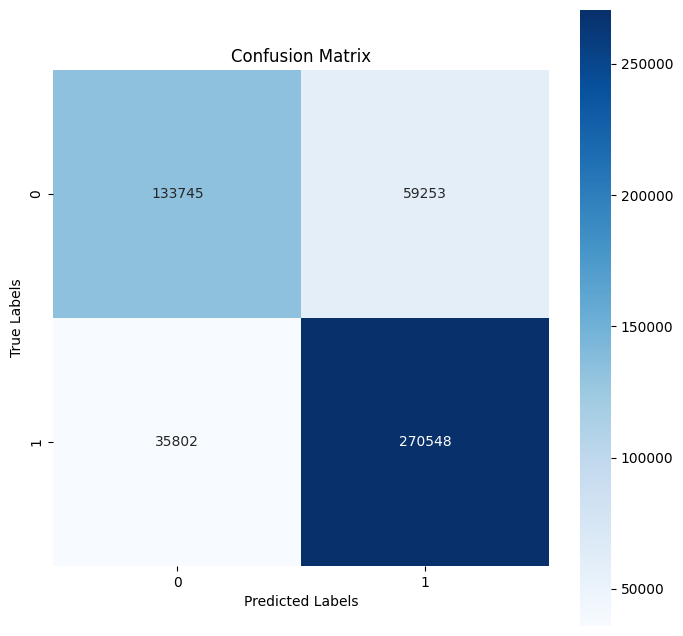

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have a test generator named test_generator

# Generate predictions
y_pred = model.predict(test_generator)
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Generate true labels from the test generator
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# **Load the Model with 5 Epochs**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
def custom_sparse_categorical_crossentropy(**kwargs):
    config = kwargs.get('config', {})
    from_logits = config.get('from_logits', False)
    reduction = config.get('reduction', 'auto')
    name = config.get('name', 'sparse_categorical_crossentropy')
    return SparseCategoricalCrossentropy(from_logits=from_logits, reduction=reduction, name=name)


In [ ]:
custom_objects = {
    'ReLU': ReLU,
    'SparseCategoricalCrossentropy': custom_sparse_categorical_crossentropy,
    'VggExtractor':VggExtractor,
    'StatsPooling':StatsPooling,
     'View':View,
    'PrimaryCapsule':PrimaryCapsule,
    'OutputCapsule':OutputCapsule,
    'RoutingLayer':RoutingLayer
}


In [ ]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from JSON
with open("model5.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json,custom_objects=custom_objects)

# Load the model weights
loaded_model.load_weights("model.weights5.h5")




80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 vgg_extractor (VggExtracto  (None, 25, 25, 256)       2325568   
 r)                                                              
                                                                 
 primary_capsule (PrimaryCa  (None, 8, 10)             1572210   
 psule)                                                          
                                                                 
 routing_layer (RoutingLaye  (None, 2, 4)              640       
 r)                                                              
                                                                 
 output_capsule (OutputCaps  (None, 2)                 0         
 ule)                                                      

# **After 7 Epochs and First Recompile with batch size 128 and balanced data**

In [ ]:
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,p
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule,clipnorm=1.0)

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

# Compile the model
loaded_model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = loaded_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=2,
    shuffle=True
)

Epoch 1/2
12104/12104 [==============================] - 4559s 373ms/step - loss: 0.4937 - accuracy: 0.8168 - val_loss: 0.4959 - val_accuracy: 0.8135
Epoch 2/2
12104/12104 [==============================] - 4472s 369ms/step - loss: 0.4873 - accuracy: 0.8246 - val_loss: 0.4952 - val_accuracy: 0.8144


3027/3027 [==============================] - 899s 296ms/step


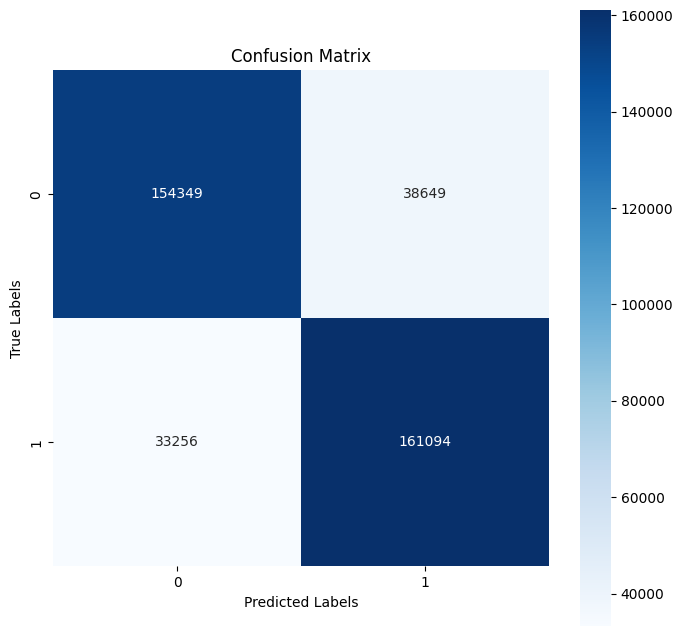

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have a test generator named test_generator

# Generate predictions
y_pred = loaded_model.predict(test_generator)
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Generate true labels from the test generator
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
loaded_model.save("recmpile_model7.keras")

# **After 9 Epochs**

In [ ]:
loaded_model7 = tf.keras.models.load_model('/content/recmpile_model7.keras', custom_objects={'CustomLayer': custom_objects})

In [ ]:
history7 = loaded_model7.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=2,
    shuffle=True
)

Epoch 1/2
12104/12104 [==============================] - 4495s 369ms/step - loss: 0.4829 - accuracy: 0.8299 - val_loss: 0.4945 - val_accuracy: 0.8151
Epoch 2/2
12104/12104 [==============================] - 4465s 369ms/step - loss: 0.4796 - accuracy: 0.8336 - val_loss: 0.4918 - val_accuracy: 0.8181


# **After 11 Epochs**

In [ ]:
history8 = loaded_model7.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=2,
    shuffle=True)

Epoch 1/2
12104/12104 [==============================] - 4462s 369ms/step - loss: 0.4768 - accuracy: 0.8367 - val_loss: 0.4951 - val_accuracy: 0.8146
Epoch 2/2
12104/12104 [==============================] - 4443s 367ms/step - loss: 0.4741 - accuracy: 0.8398 - val_loss: 0.4847 - val_accuracy: 0.8271


In [ ]:
loaded_model7.save("recmpile_model(4epochs(3:6)).keras")

In [ ]:
loaded_model7.save("recmpile_model(4epochs(3:6)).h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **After 12 epochs And Second Recompile**

In [ ]:
loaded_model8 = tf.keras.models.load_model('/content/recmpile_model(4epochs(3:6)).keras', custom_objects={'CustomLayer': custom_objects})

In [ ]:
loaded_model9 = tf.keras.models.load_model('/content/recmpile_model(4epochs(3:6)).h5', custom_objects={'CustomLayer': custom_objects})

In [ ]:
initial_learning_rate = 1e-5
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=50000,
    decay_rate=0.90,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule,clipnorm=0.5)

# Compile the model
loaded_model9.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history9 = loaded_model9.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=1,
    shuffle=True)

12104/12104 [==============================] - 4494s 369ms/step - loss: 0.4591 - accuracy: 0.8580 - val_loss: 0.4751 - val_accuracy: 0.8374


In [ ]:
loaded_model9.save("modelE13A86SecRecom.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model9.save("modelE13A86R2.keras")

# **After 13 epochs And Second Recompile**

In [ ]:
history10 = loaded_model9.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=1,
    shuffle=True)

12104/12104 [==============================] - 4463s 369ms/step - loss: 0.4562 - accuracy: 0.8614 - val_loss: 0.4745 - val_accuracy: 0.8381


In [ ]:
loaded_model9.save("modelE14A86,14R2.keras")

In [ ]:
loaded_model9.save("modelE14A86,14SecRecom.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **After 14 Epochs, Third Recompile**

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [20]:
def custom_sparse_categorical_crossentropy(**kwargs):
    config = kwargs.get('config', {})
    from_logits = config.get('from_logits', False)
    reduction = config.get('reduction', 'auto')
    name = config.get('name', 'sparse_categorical_crossentropy')
    return SparseCategoricalCrossentropy(from_logits=from_logits, reduction=reduction, name=name)


In [21]:
custom_objects = {
    'ReLU': ReLU,
    'SparseCategoricalCrossentropy': custom_sparse_categorical_crossentropy,
    'VggExtractor':VggExtractor,
    'StatsPooling':StatsPooling,
     'View':View,
    'PrimaryCapsule':PrimaryCapsule,
    'OutputCapsule':OutputCapsule,
    'RoutingLayer':RoutingLayer
}


In [41]:
loaded_model10 = tf.keras.models.load_model('modelE13A86,14R2.h5', custom_objects={'CustomLayer': custom_objects})

In [42]:
initial_learning_rate = 1e-6
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=2000,
    decay_rate=0.90,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule,clipnorm=1.0)

# Compile the model
loaded_model10.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
history10 = loaded_model10.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=1,
    shuffle=True)

12104/12104 [==============================] - 4538s 372ms/step - loss: 0.4584 - accuracy: 0.8587 - val_loss: 0.4554 - val_accuracy: 0.8624


3027/3027 [==============================] - 907s 299ms/step


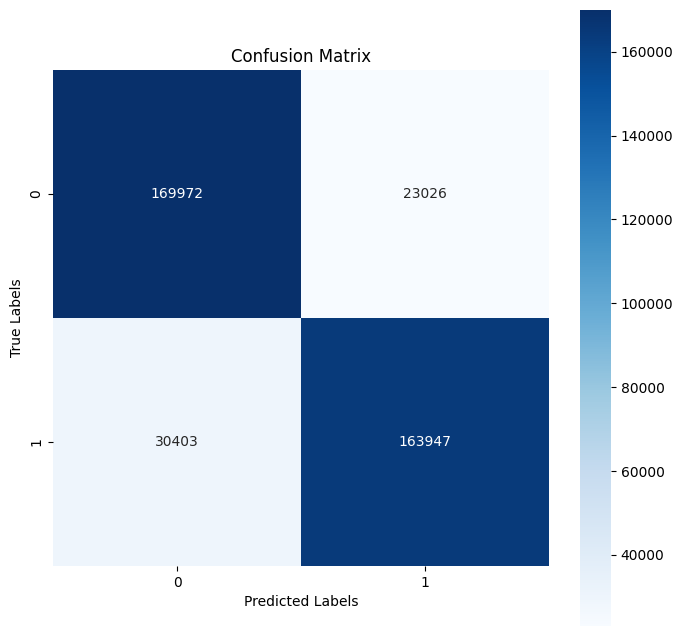

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have a test generator named test_generator

# Generate predictions
y_pred = loaded_model10.predict(test_generator)
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Generate true labels from the test generator
y_true = test_generator.classes
# Generate the confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [46]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86    192998
           1       0.88      0.84      0.86    194350

    accuracy                           0.86    387348
   macro avg       0.86      0.86      0.86    387348
weighted avg       0.86      0.86      0.86    387348



In [48]:
loaded_model10.save("modelE14VA86,24R3.h5")

# **After 17 Epochs**

In [59]:
loaded_model11 = tf.keras.models.load_model('modelE14VA86,24R3.h5', custom_objects={'CustomLayer': custom_objects})

In [60]:
initial_learning_rate = 1e-6
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=15000,
    decay_rate=0.90,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule,clipnorm=0.5)

# Compile the model
loaded_model11.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [61]:
history11 = loaded_model11.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=2,
    shuffle=True) # loss: 0.4584 - accuracy: 0.8587 - val_loss: 0.4554 - val_accuracy: 0.8624

Epoch 1/2
12104/12104 [==============================] - 4568s 375ms/step - loss: 0.4580 - accuracy: 0.8592 - val_loss: 0.4553 - val_accuracy: 0.8622
Epoch 2/2
12104/12104 [==============================] - 4536s 375ms/step - loss: 0.4578 - accuracy: 0.8594 - val_loss: 0.4553 - val_accuracy: 0.8624


In [62]:
loaded_model11.save("modelE16A85,94R3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
history11 = loaded_model11.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=1,
    shuffle=True)

12104/12104 [==============================] - 4528s 374ms/step - loss: 0.4577 - accuracy: 0.8596 - val_loss: 0.4553 - val_accuracy: 0.8624


In [64]:
loaded_model11.save("modelE16A85,96R3.h5")

# **After 18 Epochs With batch size 256 -modelE16A85,96R3.h5-**

In [72]:
loaded_model12 = tf.keras.models.load_model('modelE16A85,96R3.h5', custom_objects={'CustomLayer': custom_objects})

In [73]:
initial_learning_rate = 1e-5
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=8000,
    decay_rate=0.90,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule,clipnorm=1.0)

# Compile the model
loaded_model12.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history12 = loaded_model12.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=1,
    shuffle=True) #loss: 0.4577 - accuracy: 0.8596 - val_loss: 0.4553 - val_accuracy: 0.8624

6052/6052 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.8605

In [75]:
loaded_model12.save("modelE18A86,05R3B256.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
